In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_cosmology import p, extract_patches
from dset import get_dataloader, load_pretrained_model
from dset import get_validation

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform2d import DWT2d
from utils import get_2dfilts, get_wavefun, low_to_high
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_2dfilts, plot_2dreconstruct, plot_wavefun

# peakcounting
from peak_counting import PeakCount, rmse

# TRIM module
sys.path.append('../../lib/trim')
from trim import TrimModel
from utils import tuple_to_tensor, tensor_to_tuple

In [2]:
# get dataloader and model
train_loader, val_loader = get_dataloader(p.data_path, 
                                          img_size=p.img_size[2],
                                          split_train_test=True,
                                          batch_size=p.batch_size) 

model = load_pretrained_model(model_name='resnet18', device=device, data_path=p.model_path)   

# validation dataset
test_loader = get_validation(p.data_path, 
                             img_size=p.img_size[2],
                             batch_size=p.batch_size)

# load results

In [3]:
# wavelet params
waves = ["db5"]
mode = "zero"
J = 4

# result path
path = opj(os.getcwd(), "results")
dirs = [wave + "_saliency_warmstart_seed=1" for wave in waves]

results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj(path, dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT2d(wave=waves[i], mode=mode, J=J, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))       
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [7]:
# define indexes
res = results[0]
mos = models[0]
lamL1wave = np.array(res['lamL1wave'])
lamL1attr = np.array(res['lamL1attr'])
lamL1wave_grid = np.unique(lamL1wave)
lamL1attr_grid = np.unique(lamL1attr)
R = len(lamL1wave_grid)
C = len(lamL1attr_grid)

# original wavelet
wt_o = DWT2d(wave='db5', mode=mode, J=J).to(device)

# collect results
dic = {'psi':{},
       'wt': {},
       'lamL1wave': {},
       'lamL1attr': {},
       'index': {}}

for r in range(R):
    for c in range(C):
        if lamL1attr_grid[c] <= 0.1 and lamL1wave_grid[r] <= 0.05:
            loc = (lamL1wave == lamL1wave_grid[r]) & (lamL1attr == lamL1attr_grid[c])
            if loc.sum() == 1: 
                loc = np.argwhere(loc).flatten()[0]
                dic['index'][(r,c)] = loc
                wt = mos[loc]
                _, psi, x = get_wavefun(wt)

                dic['wt'][(r,c)] = wt
                dic['psi'][(r,c)] = psi     
                dic['lamL1wave'][(r,c)] = lamL1wave_grid[r]
                dic['lamL1attr'][(r,c)] = lamL1attr_grid[c]


# best range of bins using heldout dataset

In [19]:
# extract kernels
kern_list = []
for wt in [wt_o] + list(dic['wt'].values()):
    filt = get_2dfilts(wt)
    h = filt[0][0]
    g = filt[0][1]
    kern_list.append(extract_patches(h, g))
    
# bds = np.linspace(0.01,0.04,10)
bds = [0.02, 0.025]
scores = np.zeros((len(bds), len(kern_list)))  

for i,b in tqdm(enumerate(bds), total=len(bds)):
    for j,kernels in tqdm(enumerate(kern_list), total=len(kern_list)):
        pcw = PeakCount(peak_counting_method='custom', 
                        bins=np.linspace(0,b,23),
                        kernels=kernels)
        pcw.fit(train_loader)
        y_preds, y_params = pcw.predict(val_loader)
        scores[i,j] = rmse(y_params, y_preds)
        pkl.dump(scores, open('results/scores_1.pkl', 'wb'))  
print(np.min(scores))

100%|██████████| 2/2 [2:31:23<00:00, 4541.60s/it]  

0.00011583839386374972


# optimal filter

In [24]:
# optimal wavelet for prediction on heldout dataset
scores = pkl.load(open('results/scores_1.pkl', 'rb'))
row, col = np.unravel_index(np.argmin(scores, axis=None), scores.shape)
bd_opt = bds[row]
idx1, idx2 = list(dic['wt'].keys())[col-1]
wt = dic['wt'][(idx1, idx2)]                

# prediction performance
filt = get_2dfilts(wt)
h = filt[0][0]
g = filt[0][1]
kernels = extract_patches(h, g)
pcw = PeakCount(peak_counting_method='custom', 
                bins=np.linspace(0,bd_opt,23),
                kernels=kernels)
pcw.fit(train_loader)
y_preds, y_params = pcw.predict(test_loader)
print(rmse(y_params, y_preds))

0.00011289951775904818


In [25]:
# original wavelet
filt = get_2dfilts(wt_o)
h = filt[0][0]
g = filt[0][1]
kernels = extract_patches(h, g)
pcw = PeakCount(peak_counting_method='custom', 
                bins=np.linspace(0,bds[np.argmin(scores[:,0])],23),
                kernels=kernels)
pcw.fit(train_loader)
y_preds, y_params = pcw.predict(test_loader)
print(rmse(y_params, y_preds))

0.00029557755259591677


# viz importance features

In [215]:
def create_mask(attributions: tuple, num):
    """ 
    Threshold attributions retaining those with top absolute attributions 
    """    
    batch_size = attributions[0].shape[0]
    J = len(attributions)
    b = torch.tensor([]).to(device)
    list_of_size = [0]    
    for j in range(J):
        a = abs(attributions[j]).reshape(batch_size, -1)
        b = torch.cat((b,a), dim=1)
        list_of_size.append(list_of_size[-1] + a.shape[1])
    sort_indexes = torch.argsort(b, dim=1, descending=True)      
    
    m = torch.zeros_like(sort_indexes)
    for i in range(batch_size):
        m[i][sort_indexes[i,:num]] = 1

    list_of_masks = []
    for j in range(J):
        n0 = list_of_size[j]
        n1 = list_of_size[j+1]
        list_of_masks.append(m[:,n0:n1].reshape(attributions[j].shape))

    return list_of_masks

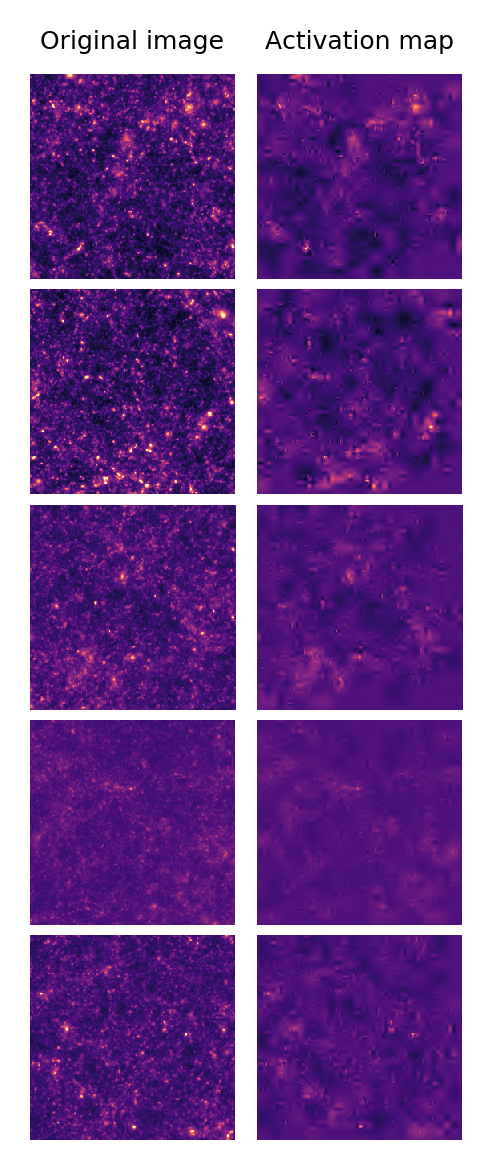

In [237]:
# trim model
mt = TrimModel(model, wt.inverse, use_residuals=True) 
attributer = Attributer(mt, attr_methods='IntegratedGradient', device=device)

# data
torch.manual_seed(2) 
data = iter(train_loader).next()[0].to(device)
num = 600

# plot
num_rows = 5
num_cols = 2
titsize = 6

fig = plt.figure(dpi=300, figsize=(2,4))

for j in range(5):
    # AWD
    data_t = wt(data[j:j+1])
    attributions = attributer(data_t, target=1, additional_forward_args=deepcopy(data)) 
    mask = create_mask(attributions, num)
    m = ()
    for i,a in enumerate(data_t):
        m += (a * mask[i],)
    data_orig = data[j:j+1]
    data_mask = wt.inverse(m)

    im1 = data_orig.detach().squeeze().cpu().numpy()
    im2 = data_mask.detach().squeeze().cpu().numpy()
    
    plt.subplot(num_rows, num_cols, j*num_cols + 1)
    plt.imshow(im1, cmap='magma', vmax=0.15, vmin=-0.05)
    plt.axis('off')
    if j == 0:
        plt.title('Original image', fontsize=titsize)
        
    plt.subplot(num_rows, num_cols, j*num_cols + 2)
    plt.imshow(im2, cmap='magma', vmax=0.15, vmin=-0.05)
    plt.axis('off') 
    if j == 0:
        plt.title('Activation map', fontsize=titsize)    
        
plt.tight_layout()
plt.subplots_adjust(wspace=-0.2, hspace=0.05)

# plt.savefig('figures/cosmo_act_map.pdf', bbox_inches='tight')

# compression

In [43]:
# define trim model
model = model.to('cpu')
wt, wt_o = wt.to('cpu'), wt_o.to('cpu')

mt = TrimModel(model, wt.inverse, use_residuals=True)    
mt_o = TrimModel(model, wt_o.inverse, use_residuals=True)  
attributer = Attributer(mt, attr_methods='Saliency', device='cpu')
attributer_o = Attributer(mt_o, attr_methods='Saliency', device='cpu')

# compute compression rate and representations
attrs = {'AWD': torch.tensor([]),
         'DB5': torch.tensor([])}
reps = {'AWD': torch.tensor([]),
        'DB5': torch.tensor([])}

for data, _ in test_loader:
    i = 0
    for w in [wt, wt_o]:
        if i == 0:
            data_t = w(data)
            with torch.backends.cudnn.flags(enabled=False):
                attributions = attributer(data_t, target=0, additional_forward_args=deepcopy(data))   
            y, _ = tuple_to_tensor(data_t)
            reps['AWD'] = torch.cat((reps['AWD'], y), dim=0)
            z, _ = tuple_to_tensor(attributions)
            attrs['AWD'] = torch.cat((attrs['AWD'], z), dim=0)
        else:
            data_t = w(data)
            with torch.backends.cudnn.flags(enabled=False):
                attributions = attributer_o(data_t, target=0, additional_forward_args=deepcopy(data))   
            y, _ = tuple_to_tensor(data_t)
            reps['DB5'] = torch.cat((reps['DB5'], y), dim=0)
            z, _ = tuple_to_tensor(attributions)
            attrs['DB5'] = torch.cat((attrs['DB5'], z), dim=0)
        i += 1
reps['AWD'] = reps['AWD'].reshape(-1)
reps['DB5'] = reps['DB5'].reshape(-1) 
attrs['AWD'] = attrs['AWD'].reshape(-1)
attrs['DB5'] = attrs['DB5'].reshape(-1) 

thresh1 = 1e-3
thresh2 = 1e-3
c_rate_AWD = 1.0*((abs(reps['AWD']) > thresh1) & (abs(attrs['AWD']) > thresh2)).sum() / reps['AWD'].shape[0]
c_rate_DB5 = 1.0*((abs(reps['DB5']) > thresh1) & (abs(attrs['DB5']) > thresh2)).sum() / reps['DB5'].shape[0]
print(c_rate_AWD.item(), c_rate_DB5.item())

0.6069852113723755 0.6201174855232239
